# Librerias & Recursos

In [46]:
%pip install pandas numpy unidecode nltk spacy matplotlib wordcloud scikit-learn tensorflow openpyxl

# Descargar el modelo de lenguaje de spaCy
!python -m spacy download en_core_web_sm

Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 50.7 MB/s eta 0:00:0000:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [1]:
import pandas as pd
import numpy as np
import re
from unidecode import unidecode
import nltk
import spacy
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
import nltk
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
warnings.filterwarnings('ignore')

2025-03-23 20:04:34.019158: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-23 20:04:34.305554: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-23 20:04:34.451488: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742760274.759333   24376 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742760274.853594   24376 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742760275.511936   24376 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [2]:
# Asegurarse de que tengamos los recursos necesarios para NLTK
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /home/codespace/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [3]:
# Install pyarrow for parquet support
%pip install pyarrow

Note: you may need to restart the kernel to use updated packages.


# Carga de Datasets

In [4]:
twitter_df = pd.read_csv('Data/Tweet_Post.csv')
twitter_df.head()

,user,text,date,emotion,sentiment
0,@erreborda,termine bien abrumado después de hoy,"Jan 6, 2024 · 2:53 AM UTC",overwhelmed,scared
1,@shpiderduck,me siento abrumado,"Jan 6, 2024 · 2:35 AM UTC",overwhelmed,scared
2,@Alex_R_art,Me siento un poco abrumado por la cantidad de ...,"Jan 6, 2024 · 12:20 AM UTC",overwhelmed,scared
3,@anggelinaa97,Salvador la única persona que no la ha abrumad...,"Jan 5, 2024 · 10:38 PM UTC",overwhelmed,scared
4,@diegoreyesvqz,Denme un helado o algo que ando full abrumado.,"Jan 5, 2024 · 8:38 PM UTC",overwhelmed,scared


In [5]:
# cargar dataset parquet en pandas
parquet_file = pd.read_parquet('Data/test-00000-of-00001-d161e0d7d20a9b0a.parquet')
travel_df = pd.DataFrame(parquet_file)
travel_df.head()

,text,label
0,Un agradable paseo por el casco antiguo de la ...,5
1,Gran llegar entrada procedente Gran ciudad en ...,4
2,Sencillamente Espectacular Para Caminarlo o en...,5
3,Monserrate y sus bellas vistas Es una visita o...,5
4,Un paraiso muy cerca de la ciudad de Mérida El...,5


# Descripción de los datos

In [6]:
twitter_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2590 entries, 0 to 2589
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   user       2590 non-null   object
 1   text       2590 non-null   object
 2   date       2590 non-null   object
 3   emotion    2590 non-null   object
 4   sentiment  2590 non-null   object
dtypes: object(5)
memory usage: 101.3+ KB


In [7]:
travel_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25171 entries, 0 to 25170
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    25171 non-null  object
 1   label   25171 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 393.4+ KB


# Pre procesamiento

## Mapear etiquetas de sentimentos segun el modelo de Sentimiento de Plutchik

In [8]:
twitter_selected = twitter_df[['text', 'sentiment']].copy()
twitter_selected.rename(columns={'text': 'post'}, inplace=True)
twitter_selected['source'] = 'Twitter'
twitter_selected.head()

,post,sentiment,source
0,termine bien abrumado después de hoy,scared,Twitter
1,me siento abrumado,scared,Twitter
2,Me siento un poco abrumado por la cantidad de ...,scared,Twitter
3,Salvador la única persona que no la ha abrumad...,scared,Twitter
4,Denme un helado o algo que ando full abrumado.,scared,Twitter


In [9]:
twitter_selected.shape

(2590, 3)

In [10]:
travel_selected = travel_df.copy()
travel_selected.rename(columns={'text': 'post', 'label': 'sentiment'}, inplace=True)
travel_selected['source'] = 'Review'
travel_selected.head()

,post,sentiment,source
0,Un agradable paseo por el casco antiguo de la ...,5,Review
1,Gran llegar entrada procedente Gran ciudad en ...,4,Review
2,Sencillamente Espectacular Para Caminarlo o en...,5,Review
3,Monserrate y sus bellas vistas Es una visita o...,5,Review
4,Un paraiso muy cerca de la ciudad de Mérida El...,5,Review


In [11]:
travel_selected.shape

(25171, 3)

In [12]:
# 2 registros del dataset de la columna post, donde sentiment = 1, que se vea completo la columna post
display(travel_selected[travel_selected['sentiment'] == 1].head(2))
display(travel_selected[travel_selected['sentiment'] == 2].head(2))
display(travel_selected[travel_selected['sentiment'] == 3].head(2))
display(travel_selected[travel_selected['sentiment'] == 4].head(2))
display(travel_selected[travel_selected['sentiment'] == 5].head(2))

,post,sentiment,source
43,Pésima opción entre servicio e instalaciones N...,1,Review
79,Aburrido Me enteré a través del museo entero c...,1,Review


,post,sentiment,source
11,"Buena comida, pero ten paciencia Este fue el p...",2,Review
87,"horrible sucio, descuidado, abandonado, muy fe...",2,Review


,post,sentiment,source
9,Información poco clara. Lugar agradable Cierra...,3,Review
19,Comida decepcionante Reservamos una mesa aquí ...,3,Review


,post,sentiment,source
1,Gran llegar entrada procedente Gran ciudad en ...,4,Review
8,Buen hotel para negocios La ubicacion del hote...,4,Review


,post,sentiment,source
0,Un agradable paseo por el casco antiguo de la ...,5,Review
2,Sencillamente Espectacular Para Caminarlo o en...,5,Review


In [13]:
# Mapear los sentimientos según el modelo de Plutchik
# Plutchik tiene 8 emociones básicas: alegría, confianza, miedo, sorpresa, tristeza, disgusto, ira, anticipación
plutchik_mapping = {
    # Twitter emotions
    'scared': 'Negativa',
    'sad': 'Negativa',
    'powerful': 'Positiva',
    'peaceful': 'Neutral',  # Podría mapearse a "confianza" en un nivel menor de intensidad
    'mad': 'Negativa',
    'joyful': 'Positiva',   

    # Hotel ratings (1-5)
    1: 'Negativa',      # Rating 1: Muy negativo, muestra ira/enojo
    2: 'Negativa',    # Rating 2: Negativo, muestra disgusto, tristeza
    3: 'Neutral',    # Rating 3: Mixto o neutral
    4: 'Positiva',        # Rating 4: Positivo, muestra alegría
    5: 'Positiva'       # Rating 5: Muy positivo, muestra confianza/admiración
}

# Aplicar mapping a los sentimientos en ambos datasets
twitter_selected['plutchik_sentiment'] = twitter_selected['sentiment'].map(plutchik_mapping)
travel_selected['plutchik_sentiment'] = travel_selected['sentiment'].map(plutchik_mapping)


print("\nResultados Mapeo de Twitter_df")
print(twitter_selected[['sentiment', 'plutchik_sentiment']].value_counts())
print("\nResultados Mapeo de TRavel_df")
print(travel_selected[['sentiment', 'plutchik_sentiment']].value_counts())


Resultados Mapeo de Twitter_df
sentiment  plutchik_sentiment
peaceful   Neutral               660
mad        Negativa              530
powerful   Positiva              420
sad        Negativa              360
joyful     Positiva              350
scared     Negativa              270
Name: count, dtype: int64

Resultados Mapeo de TRavel_df
sentiment  plutchik_sentiment
5          Positiva              15710
4          Positiva               6023
3          Neutral                2166
2          Negativa                695
1          Negativa                577
Name: count, dtype: int64


## Balanceo de clases

In [14]:
def graficar_balance_clases(dataset, nombre, columna_sentimiento, palette=None):
    """
    Grafica el balance de clases de una columna de sentimientos en un dataset.

    Parámetros:
    - dataset: DataFrame que contiene los datos.
    - columna_sentimiento: Nombre de la columna que contiene los sentimientos.
    - palette: Diccionario con los colores para cada sentimiento (opcional).
    """
    # Verificar el balance de clases
    class_counts = dataset[columna_sentimiento].value_counts()
    print(f"\nConteo de clases en el dataset:{nombre}")
    print(class_counts)

    # Graficar el balance de clases
    plt.figure(figsize=(10, 6))
    sns.countplot(
        data=dataset,
        x=columna_sentimiento,
        palette=palette,  # Usar la paleta personalizada si se proporciona
        order=palette.keys() if palette else None  # Ordenar según el diccionario si se proporciona
    )

    # Añadir título y etiquetas
    plt.title(f'Balance de Clases en el Dataset {nombre}', fontsize=16, fontweight='bold')
    plt.xlabel('Sentimiento', fontsize=14)
    plt.ylabel('Frecuencia', fontsize=14)

    # Mejorar la visualización de los ejes
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # Mostrar la gráfica
    plt.show()

In [15]:
# balanceo de las clases sin eliminar ninguna clase solo reduciendo el número de ejemplos de la clase mayoritaria
def balance_classes(df, target_col):
    # Obtener el conteo de cada clase
    class_counts = df

    class_counts = df[target_col].value_counts()
    min_count = class_counts.min()
    print(f"Conteo mínimo de clases: {min_count}")
    print(f"Conteo de clases antes del balanceo:\n{class_counts}")

    # Crear un nuevo DataFrame para almacenar los datos balanceados
    balanced_df = pd.DataFrame()
    for sentiment in class_counts.index:
        # Filtrar los ejemplos de la clase actual
        class_df = df[df[target_col] == sentiment]
        
        # Si la clase tiene más ejemplos que el mínimo, reducir su tamaño
        if len(class_df) > min_count:
            class_df = class_df.sample(min_count, random_state=42)
        
        # Añadir los ejemplos balanceados al DataFrame final
        balanced_df = pd.concat([balanced_df, class_df], ignore_index=True)
            
    # Reiniciar el índice del DataFrame balanceado
    balanced_df.reset_index(drop=True, inplace=True)
    
    # Mostrar el conteo de clases después del balanceo
    print(f"\nConteo de clases después del balanceo:\n{balanced_df[target_col].value_counts()}")
    
    return balanced_df

In [16]:
# Definir la paleta de colores según el modelo de Plutchik
plutchik_palette = {
    "Positiva": "yellow",
    "Negativa": "lightcoral",
    "Neutral": "gray",
}


Conteo de clases en el dataset:twitter_df
plutchik_sentiment
Negativa    1160
Positiva     770
Neutral      660
Name: count, dtype: int64


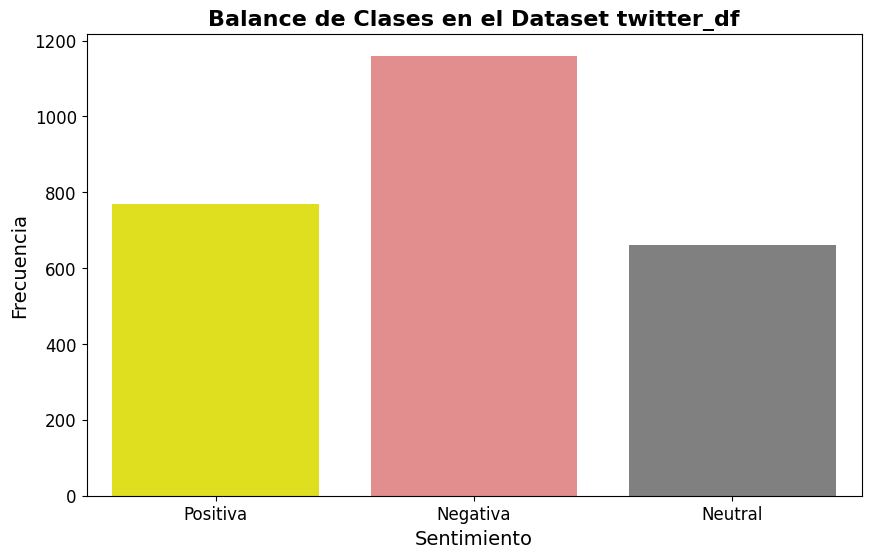

In [17]:
# Verificar el balance de clases en twitter_df
graficar_balance_clases(twitter_selected, 'twitter_df', 'plutchik_sentiment', palette=plutchik_palette)


Conteo de clases en el dataset:travel_df
plutchik_sentiment
Positiva    21733
Neutral      2166
Negativa     1272
Name: count, dtype: int64


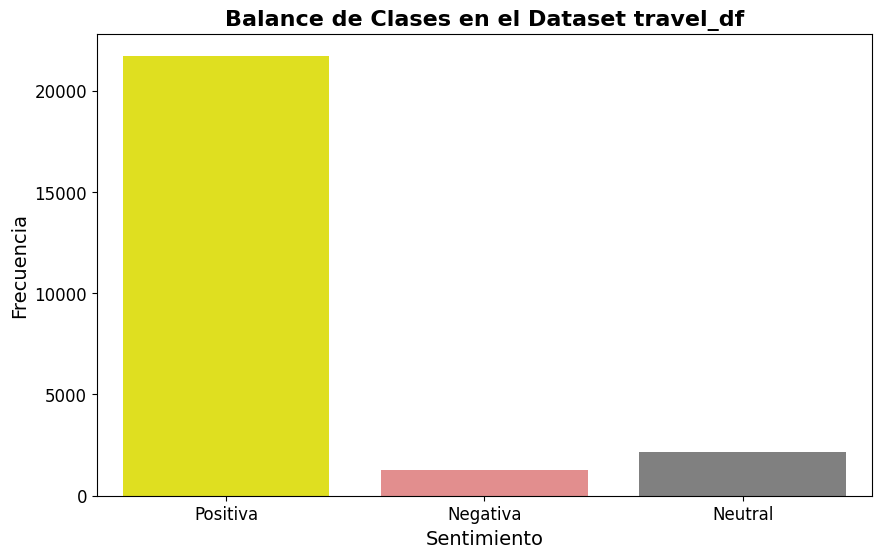

In [18]:
# Verificar el balance de clases en travel_df
graficar_balance_clases(travel_selected,'travel_df','plutchik_sentiment', palette=plutchik_palette)

In [19]:
# Balancear las clases del DataFrame de viajes
travel_balanced = balance_classes(travel_selected, 'plutchik_sentiment')

Conteo mínimo de clases: 1272
Conteo de clases antes del balanceo:
plutchik_sentiment
Positiva    21733
Neutral      2166
Negativa     1272
Name: count, dtype: int64

Conteo de clases después del balanceo:
plutchik_sentiment
Positiva    1272
Neutral     1272
Negativa    1272
Name: count, dtype: int64


In [20]:
travel_balanced['plutchik_sentiment'].value_counts()

plutchik_sentiment
Positiva    1272
Neutral     1272
Negativa    1272
Name: count, dtype: int64

## Combinar los datasets

In [21]:
# Merge los dos datasets
merged_df = pd.concat([twitter_selected, travel_balanced], ignore_index=True)

# Reset index
merged_df.reset_index(drop=True, inplace=True)

# Check merged dataset
print("\nIngformación Merged Dataset:")
print(merged_df.info())
print("\nPrimeras filas del Merged Dataset:")
merged_df.head()


Ingformación Merged Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6406 entries, 0 to 6405
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   post                6406 non-null   object
 1   sentiment           6406 non-null   object
 2   source              6406 non-null   object
 3   plutchik_sentiment  6406 non-null   object
dtypes: object(4)
memory usage: 200.3+ KB
None

Primeras filas del Merged Dataset:


,post,sentiment,source,plutchik_sentiment
0,termine bien abrumado después de hoy,scared,Twitter,Negativa
1,me siento abrumado,scared,Twitter,Negativa
2,Me siento un poco abrumado por la cantidad de ...,scared,Twitter,Negativa
3,Salvador la única persona que no la ha abrumad...,scared,Twitter,Negativa
4,Denme un helado o algo que ando full abrumado.,scared,Twitter,Negativa



Conteo de clases en el dataset:merged_df
plutchik_sentiment
Negativa    2432
Positiva    2042
Neutral     1932
Name: count, dtype: int64


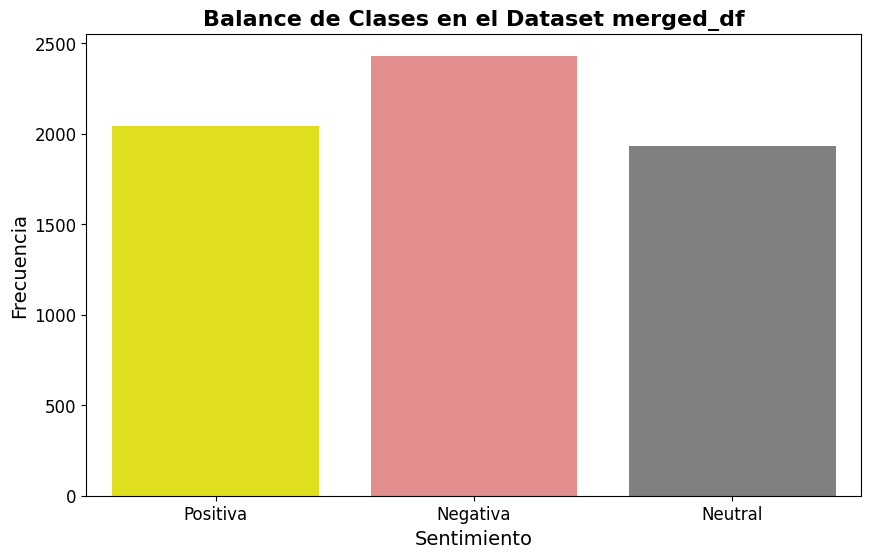

In [22]:
# Verificar el balance de clases en travel_df
graficar_balance_clases(merged_df, 'merged_df','plutchik_sentiment', palette=plutchik_palette)

## Transformación del texto

In [23]:
def normalize_text(text):
    """
    Normalize text by:
    1. Removing special characters (keeping Spanish letters and accents)
    2. Removing words with characters repeated more than twice
    3. Joining hyphenated words
    4. Converting to lowercase
    5. Removing tildes and the letter "ñ"
    """
    if not isinstance(text, str):
        return ""
    
    # Remove tildes and the letter "ñ" using unidecode
    text = unidecode(text)
    
    # Remove special characters (keeping only letters and spaces)
    letters_only = re.sub(r"[^A-Za-z\s]", " ", text)
    
    # Remove repeated characters (more than 2 times)
    no_repeats = re.sub(r"(.)\1{2,}", r"\1\1", letters_only)
    
    # Join hyphenated words
    no_hyphens = re.sub(r"([A-Za-z]+)-([A-Za-z]+)", r"\1\2", no_repeats)
    
    # Convert to lowercase
    lowercase = no_hyphens.lower()
    
    # Remove extra whitespace
    cleaned = re.sub(r"\s+", " ", lowercase).strip()
    
    return cleaned

In [24]:
merged_df['normalized_text'] = merged_df['post'].apply(normalize_text)
print("\nEjemplos Normalizacion:")
for i in range(min(5, len(merged_df))):
    print(f"Original: {merged_df.loc[i, 'post']}")
    print(f"Normalizado: {merged_df.loc[i, 'normalized_text']}")
    print("-" * 50)


Ejemplos Normalizacion:
Original: termine bien abrumado después de hoy
Normalizado: termine bien abrumado despues de hoy
--------------------------------------------------
Original: me siento abrumado
Normalizado: me siento abrumado
--------------------------------------------------
Original: Me siento un poco abrumado por la cantidad de cosas que quiero dibujar, ver, jugar y leer. Odio esta sensación xdddd
Normalizado: me siento un poco abrumado por la cantidad de cosas que quiero dibujar ver jugar y leer odio esta sensacion xdd
--------------------------------------------------
Original: Salvador la única persona que no la ha abrumado de versiones❤😒❤ #NadieComoTú
Normalizado: salvador la unica persona que no la ha abrumado de versiones nadiecomotu
--------------------------------------------------
Original: Denme un helado o algo que ando full abrumado.
Normalizado: denme un helado o algo que ando full abrumado
--------------------------------------------------


In [25]:
def tokenize_text(text):
    """
    Tokenize text into individual words
    """
    if not isinstance(text, str) or not text:
        return []
    
    tokens = word_tokenize(text)
    return tokens

In [26]:
# Apply tokenization to the normalized text
merged_df['tokens'] = merged_df['normalized_text'].apply(tokenize_text)

# Show examples of tokenization
print("\nEjemplo Tokenizacion:")
for i in range(min(5, len(merged_df))):
    print(f"Normalized: {merged_df.loc[i, 'normalized_text']}")
    print(f"Tokens: {merged_df.loc[i, 'tokens']}")
    print("-" * 50)


Ejemplo Tokenizacion:
Normalized: termine bien abrumado despues de hoy
Tokens: ['termine', 'bien', 'abrumado', 'despues', 'de', 'hoy']
--------------------------------------------------
Normalized: me siento abrumado
Tokens: ['me', 'siento', 'abrumado']
--------------------------------------------------
Normalized: me siento un poco abrumado por la cantidad de cosas que quiero dibujar ver jugar y leer odio esta sensacion xdd
Tokens: ['me', 'siento', 'un', 'poco', 'abrumado', 'por', 'la', 'cantidad', 'de', 'cosas', 'que', 'quiero', 'dibujar', 'ver', 'jugar', 'y', 'leer', 'odio', 'esta', 'sensacion', 'xdd']
--------------------------------------------------
Normalized: salvador la unica persona que no la ha abrumado de versiones nadiecomotu
Tokens: ['salvador', 'la', 'unica', 'persona', 'que', 'no', 'la', 'ha', 'abrumado', 'de', 'versiones', 'nadiecomotu']
--------------------------------------------------
Normalized: denme un helado o algo que ando full abrumado
Tokens: ['denme', 'un',

In [27]:
def remove_stopwords(tokens):
    """
    Remove Spanish stopwords from a list of tokens
    """
    if not tokens:
        return []
    
    spanish_stopwords = set(stopwords.words('spanish'))
    filtered_tokens = [token for token in tokens if token not in spanish_stopwords]
    return filtered_tokens

In [28]:
# Apply stopword removal to the tokens
merged_df['filtered_tokens'] = merged_df['tokens'].apply(remove_stopwords)

# Show examples of stopword removal
print("\nEjemplos Remocion Stopword:")
for i in range(min(5, len(merged_df))):
    print(f"Tokens: {merged_df.loc[i, 'tokens']}")
    print(f"Despues de remover Stopword: {merged_df.loc[i, 'filtered_tokens']}")
    print("-" * 50)


Ejemplos Remocion Stopword:
Tokens: ['termine', 'bien', 'abrumado', 'despues', 'de', 'hoy']
Despues de remover Stopword: ['termine', 'bien', 'abrumado', 'despues', 'hoy']
--------------------------------------------------
Tokens: ['me', 'siento', 'abrumado']
Despues de remover Stopword: ['siento', 'abrumado']
--------------------------------------------------
Tokens: ['me', 'siento', 'un', 'poco', 'abrumado', 'por', 'la', 'cantidad', 'de', 'cosas', 'que', 'quiero', 'dibujar', 'ver', 'jugar', 'y', 'leer', 'odio', 'esta', 'sensacion', 'xdd']
Despues de remover Stopword: ['siento', 'abrumado', 'cantidad', 'cosas', 'quiero', 'dibujar', 'ver', 'jugar', 'leer', 'odio', 'sensacion', 'xdd']
--------------------------------------------------
Tokens: ['salvador', 'la', 'unica', 'persona', 'que', 'no', 'la', 'ha', 'abrumado', 'de', 'versiones', 'nadiecomotu']
Despues de remover Stopword: ['salvador', 'unica', 'persona', 'abrumado', 'versiones', 'nadiecomotu']
------------------------------------

In [29]:
try:
    nlp = spacy.load('es_core_news_sm')
except:
    # If model not found, download it
    import sys
    !{sys.executable} -m spacy download es_core_news_sm
    nlp = spacy.load('es_core_news_sm')

def lemmatize_tokens(tokens):
    """
    Lemmatize a list of tokens using spaCy's Spanish model
    """
    if not tokens:
        return []
    
    # Join tokens back into text for spaCy processing
    text = ' '.join(tokens)
    doc = nlp(text)
    
    # Extract lemmas
    lemmas = [token.lemma_.lower() for token in doc if token.lemma_.strip()]
    
    return lemmas

In [30]:
# Inicializar el lematizador de NLTK
# lemmatizer = WordNetLemmatizer()

# # Función para convertir etiquetas POS de NLTK a WordNet
# def get_wordnet_pos(treebank_tag):
#     """
#     Mapea las etiquetas POS de NLTK a las etiquetas POS de WordNet.
#     """
#     if treebank_tag.startswith('J'):
#         return wordnet.ADJ
#     elif treebank_tag.startswith('V'):
#         return wordnet.VERB
#     elif treebank_tag.startswith('N'):
#         return wordnet.NOUN
#     elif treebank_tag.startswith('R'):
#         return wordnet.ADV
#     else:
#         return wordnet.NOUN  # Por defecto, asumimos sustantivo

# def lemmatize_tokens(tokens):
#     """
#     Lemmatiza una lista de tokens usando NLTK.
#     """
#     if not tokens:
#         return []
    
#     # Obtener las etiquetas POS de los tokens
#     pos_tags = nltk.pos_tag(tokens)
    
#     # Lematizar cada token con su etiqueta POS correspondiente
#     lemmas = []
#     for token, pos_tag in pos_tags:
#         wordnet_pos = get_wordnet_pos(pos_tag)
#         lemma = lemmatizer.lemmatize(token, pos=wordnet_pos)
#         lemmas.append(lemma.lower())
    
#     return lemmas

In [31]:
# Apply lemmatization to the filtered tokens
merged_df['lemmas'] = merged_df['filtered_tokens'].apply(lemmatize_tokens)

# Show examples of lemmatization
print("\nEjemplos Lemmatizacion:")
for i in range(min(5, len(merged_df))):
    print(f"Tokens: {merged_df.loc[i, 'filtered_tokens']}")
    print(f"Lemmas: {merged_df.loc[i, 'lemmas']}")
    print("-" * 50)


Ejemplos Lemmatizacion:
Tokens: ['termine', 'bien', 'abrumado', 'despues', 'hoy']
Lemmas: ['terminar', 'bien', 'abrumado', 'despu', 'hoy']
--------------------------------------------------
Tokens: ['siento', 'abrumado']
Lemmas: ['sentir', 'abrumado']
--------------------------------------------------
Tokens: ['siento', 'abrumado', 'cantidad', 'cosas', 'quiero', 'dibujar', 'ver', 'jugar', 'leer', 'odio', 'sensacion', 'xdd']
Lemmas: ['sentir', 'abrumado', 'cantidad', 'cosa', 'querer', 'dibujar', 'ver', 'jugar', 'leer', 'odio', 'sensacion', 'xdd']
--------------------------------------------------
Tokens: ['salvador', 'unica', 'persona', 'abrumado', 'versiones', 'nadiecomotu']
Lemmas: ['salvador', 'unico', 'persona', 'abrumado', 'versión', 'nadiecomotu']
--------------------------------------------------
Tokens: ['denme', 'helado', 'ando', 'full', 'abrumado']
Lemmas: ['denmir', 'helado', 'ar', 'full', 'abrumado']
--------------------------------------------------


In [32]:
# Combinar lemmas en un solo string para cada fila
merged_df['clean_text'] = merged_df['lemmas'].apply(lambda x: ' '.join(x) if x else '')

\Generando Word Cloud para los Textos:


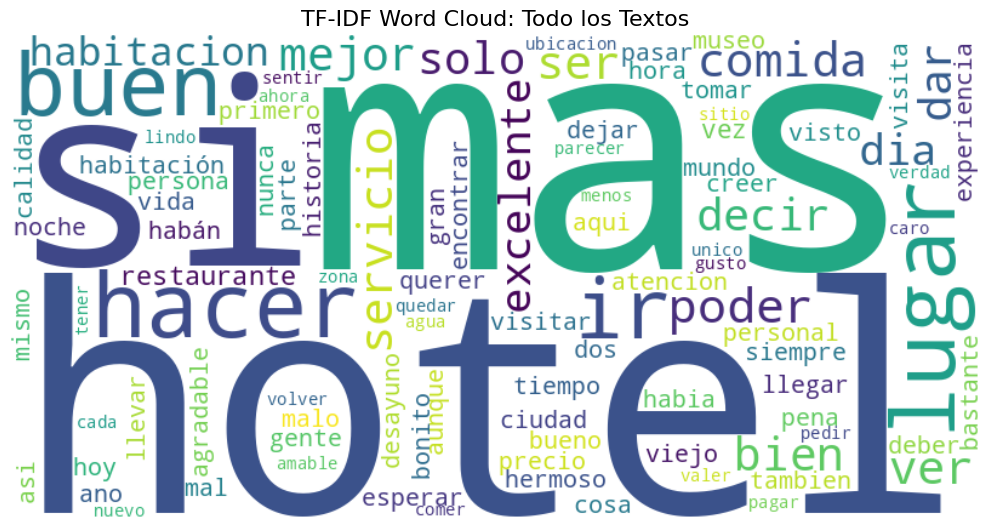

In [33]:
# Create a TF-IDF word cloud for each sentiment category

# Create a function to generate word clouds from TF-IDF values
def generate_tfidf_wordcloud(texts, title, max_words=100):
    """
    Generate a word cloud based on TF-IDF values for a collection of texts
    """
    # Create a TF-IDF vectorizer
    tfidf_vectorizer = TfidfVectorizer(
        max_features=1000,
        stop_words=stopwords.words('spanish'),
        ngram_range=(1, 2)  # Include both single words and bigrams
    )
    
    # Fit and transform the texts
    tfidf_matrix = tfidf_vectorizer.fit_transform(texts)
    
    # Get feature names and their TF-IDF scores
    feature_names = tfidf_vectorizer.get_feature_names_out()
    
    # Sum TF-IDF values across documents for each word
    tfidf_sum = np.array(tfidf_matrix.sum(axis=0)).flatten()
    
    # Create a dictionary of word -> TF-IDF score
    word_tfidf = {feature_names[i]: tfidf_sum[i] for i in range(len(feature_names))}
    
    # Create and display word cloud
    plt.figure(figsize=(10, 6))
    wordcloud = WordCloud(
        width=800, 
        height=400, 
        background_color='white',
        max_words=max_words,
        colormap='viridis',
        contour_width=1,
        contour_color='steelblue'
    ).generate_from_frequencies(word_tfidf)
    
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Generate a word cloud for all texts
print("\Generando Word Cloud para los Textos:")
all_texts = merged_df['clean_text'].tolist()
generate_tfidf_wordcloud(all_texts, 'TF-IDF Word Cloud: Todo los Textos')


Generando Word Clouds por Categorias de Sentimiento:


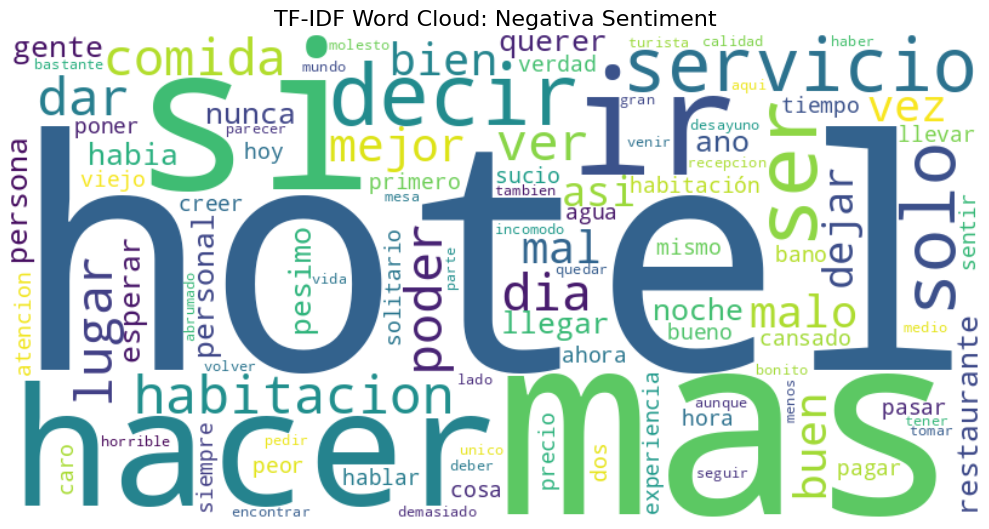

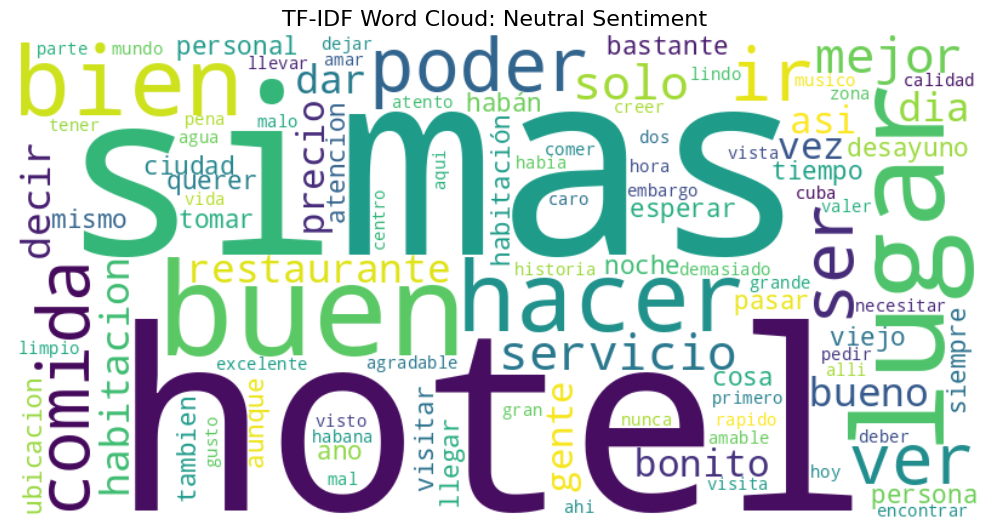

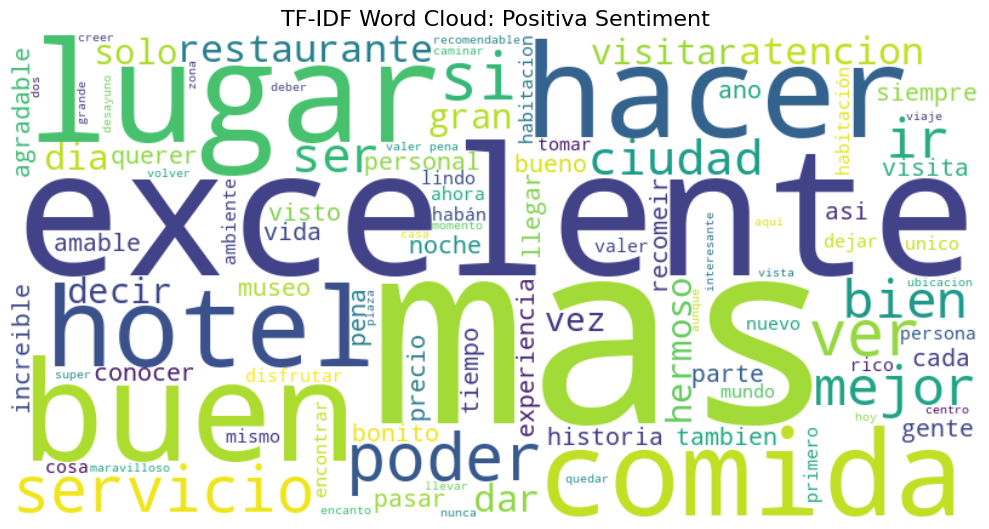

In [34]:
# Generate word clouds for each sentiment category
print("\nGenerando Word Clouds por Categorias de Sentimiento:")
for sentiment in merged_df['plutchik_sentiment'].dropna().unique():
    sentiment_texts = merged_df[merged_df['plutchik_sentiment'] == sentiment]['clean_text'].dropna().tolist()
    if sentiment_texts:
        generate_tfidf_wordcloud(sentiment_texts, f'TF-IDF Word Cloud: {sentiment.title()} Sentiment')

In [35]:
# Final processed dataset summary
print("\nResumen Final")
print(f"Numero total de post: {len(merged_df)}")
print(f"Numero de post por fuente: {merged_df['source'].value_counts().to_dict()}")
print(f"Numero de post por sentimiento: {merged_df['plutchik_sentiment'].value_counts().to_dict()}")


Resumen Final
Numero total de post: 6406
Numero de post por fuente: {'Review': 3816, 'Twitter': 2590}
Numero de post por sentimiento: {'Negativa': 2432, 'Positiva': 2042, 'Neutral': 1932}


In [36]:
merged_df.head()

,post,sentiment,source,plutchik_sentiment,normalized_text,tokens,filtered_tokens,lemmas,clean_text
0,termine bien abrumado después de hoy,scared,Twitter,Negativa,termine bien abrumado despues de hoy,"[termine, bien, abrumado, despues, de, hoy]","[termine, bien, abrumado, despues, hoy]","[terminar, bien, abrumado, despu, hoy]",terminar bien abrumado despu hoy
1,me siento abrumado,scared,Twitter,Negativa,me siento abrumado,"[me, siento, abrumado]","[siento, abrumado]","[sentir, abrumado]",sentir abrumado
2,Me siento un poco abrumado por la cantidad de ...,scared,Twitter,Negativa,me siento un poco abrumado por la cantidad de ...,"[me, siento, un, poco, abrumado, por, la, cant...","[siento, abrumado, cantidad, cosas, quiero, di...","[sentir, abrumado, cantidad, cosa, querer, dib...",sentir abrumado cantidad cosa querer dibujar v...
3,Salvador la única persona que no la ha abrumad...,scared,Twitter,Negativa,salvador la unica persona que no la ha abrumad...,"[salvador, la, unica, persona, que, no, la, ha...","[salvador, unica, persona, abrumado, versiones...","[salvador, unico, persona, abrumado, versión, ...",salvador unico persona abrumado versión nadiec...
4,Denme un helado o algo que ando full abrumado.,scared,Twitter,Negativa,denme un helado o algo que ando full abrumado,"[denme, un, helado, o, algo, que, ando, full, ...","[denme, helado, ando, full, abrumado]","[denmir, helado, ar, full, abrumado]",denmir helado ar full abrumado


In [37]:
# Save the processed dataset to a CSV file
processed_file_path = 'Data/processed_sentiment_data.csv'
merged_df.to_csv(processed_file_path, index=False)
print(f"\nGuardado como: {processed_file_path}")


Guardado como: Data/processed_sentiment_data.csv


# Redes Neuronales

In [38]:
# Split
X = merged_df['clean_text']
X

0                        terminar bien abrumado despu hoy
1                                         sentir abrumado
2       sentir abrumado cantidad cosa querer dibujar v...
3       salvador unico persona abrumado versión nadiec...
4                          denmir helado ar full abrumado
                              ...                        
6401    desastroso checking llega hotel despues cansan...
6402    malo atencion relegado mal atendido comida esp...
6403    servia teleferico alla llegar decir teleferico...
6404    buena vacación hotel pequeno nuevo vallarta li...
6405    decepcion ubicacion buen atencion excelente ma...
Name: clean_text, Length: 6406, dtype: object

In [39]:
y = merged_df['plutchik_sentiment']
y

0       Negativa
1       Negativa
2       Negativa
3       Negativa
4       Negativa
          ...   
6401    Negativa
6402    Negativa
6403    Negativa
6404    Negativa
6405    Negativa
Name: plutchik_sentiment, Length: 6406, dtype: object

In [40]:
# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [41]:
# Convertir etiquetas a formato numérico
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
num_classes = len(label_encoder.classes_)

In [42]:
num_classes

3

In [43]:
# Configuración para tokenización y secuencias
max_words = 15000
max_length = 150
embedding_dim = 256

In [44]:
# Crear y ajustar tokenizador
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

In [45]:
# Convertir textos a secuencias
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [47]:
# Padding para tener secuencias de igual longitud
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length)

In [48]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=max_length))
model.add(Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(64, dropout=0.2)))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.4))
model.add(Dense(num_classes, activation='softmax'))

2025-03-23 20:20:43.658074: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [49]:
optimizer = Adam(learning_rate=0.0005)
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

In [50]:
# Entrenar el modelo
history = model.fit(
    X_train_pad, y_train_encoded,
    validation_split=0.1,
    epochs=10,
    batch_size=32
)

Epoch 1/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 113s 724ms/step - accuracy: 0.3776 - loss: 1.1627 - val_accuracy: 0.5789 - val_loss: 0.9692
Epoch 2/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 138s 697ms/step - accuracy: 0.6586 - loss: 0.8154 - val_accuracy: 0.6140 - val_loss: 0.9037
Epoch 3/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 141s 694ms/step - accuracy: 0.8401 - loss: 0.4785 - val_accuracy: 0.5945 - val_loss: 1.1312
Epoch 4/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 101s 693ms/step - accuracy: 0.9237 - loss: 0.2798 - val_accuracy: 0.6296 - val_loss: 1.2193
Epoch 5/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 100s 693ms/step - accuracy: 0.9666 - loss: 0.1623 - val_accuracy: 0.6296 - val_loss: 1.3339
Epoch 6/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 141s 688ms/step - accuracy: 0.9782 - loss: 0.1236 - val_accuracy: 0.6452 - val_loss: 1.2686
Epoch 7/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 102s 701ms/step - accuracy: 0.9789 - loss: 0.1185 - val_accuracy: 0.6589 - val_loss: 1.3732
Epoch 8/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 140s 685ms/step - accuracy: 0.9866 -

In [51]:
# Predicciones y reporte de clasificación
y_pred = model.predict(X_test_pad)
y_pred_classes = np.argmax(y_pred, axis=1)
print(classification_report(y_test_encoded, y_pred_classes, target_names=label_encoder.classes_))

41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 152ms/step
              precision    recall  f1-score   support

    Negativa       0.72      0.74      0.73       499
     Neutral       0.51      0.53      0.52       393
    Positiva       0.67      0.61      0.64       390

    accuracy                           0.64      1282
   macro avg       0.63      0.63      0.63      1282
weighted avg       0.64      0.64      0.64      1282



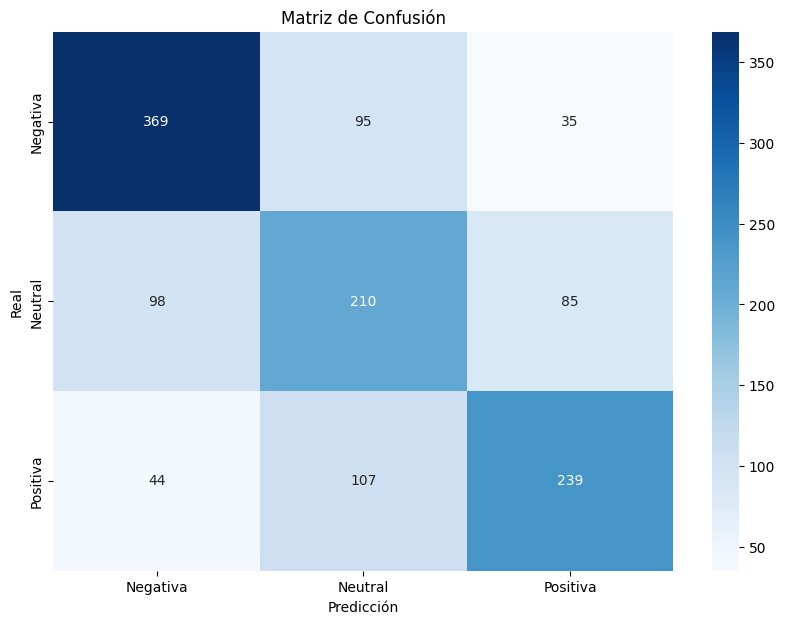

In [52]:
#matriz de confusión
cm = confusion_matrix(y_test_encoded, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

In [52]:
# Predicciones y reporte de clasificación
y_pred = model.predict(X_test_pad)
y_pred_classes = np.argmax(y_pred, axis=1)
print(classification_report(y_test_encoded, y_pred_classes, target_names=label_encoder.classes_))

35/35 ━━━━━━━━━━━━━━━━━━━━ 13s 336ms/step
              precision    recall  f1-score   support

  aceptacion       0.38      0.31      0.34       111
     alegria       0.41      0.24      0.31       184
   confianza       0.36      0.65      0.46       191
         ira       0.52      0.45      0.48       236
       miedo       0.00      0.00      0.00        62
   serenidad       0.54      0.56      0.55       135
    tristeza       0.33      0.39      0.36       176

    accuracy                           0.41      1095
   macro avg       0.36      0.37      0.36      1095
weighted avg       0.40      0.41      0.40      1095

